In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
pip install catboost

     |████████████████████████████████| 64.8MB 60kB/s 


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score,f1_score

from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from imblearn.over_sampling import SMOTE 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb

from catboost import CatBoostClassifier, Pool

from scipy import stats

RANDOM_SEED = 8    # Set a random seed for reproducibility!

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 100)

DATA_PATH = Path.cwd().parent / "data" / "final" / "public"

features_label_df = pd.read_csv(
    DATA_PATH / "/content/drive/My Drive/Fare Classification/train.csv", 
    index_col="tripid"
)
features_label_df['label'] = features_label_df['label'].astype('category')
encode_map = {
    'correct': 1,
    'incorrect': 0
}

features_label_df['label'].replace(encode_map, inplace=True)
features_label_df = features_label_df[features_label_df['fare'].notna()]
features_df = features_label_df.iloc[:, 0:-1]
label_df = features_label_df[['label']]
test_features_df = pd.read_csv(
    DATA_PATH / "/content/drive/My Drive/Fare Classification/test.csv", 
    index_col="tripid"
)

print("features_df.shape", features_df.shape)
print("label_df.shape", label_df.shape)


features_df.shape (17039, 12)
label_df.shape (17039, 1)


In [ ]:
features_pickup = pd.to_datetime(features_df["pickup_time"])
features_df.insert(6, 'day', features_pickup.dt.dayofweek)

features_df.insert(6, 'hour', features_pickup.dt.hour)
features_df.loc[np.logical_or(features_df['hour'] <= 6, features_df['hour'] >= 18), 'Night'] = 'True' 
features_df.loc[np.logical_and(18 > features_df['hour'] , features_df['hour'] > 6), 'Night'] = 'False' 

features_df.loc[ 5 > features_df['day'], 'DayoftheWeek'] = 'WeekDay'
features_df.loc[ 5 <= features_df['day'], 'DayoftheWeek'] = 'WeekendDay'


features_df['lat_diff'] = abs(features_df['pick_lat'] - features_df['drop_lat'])
features_df['lon_diff'] = abs(features_df['pick_lon'] - features_df['drop_lon'])
features_df['shortest_path'] = (features_df['lat_diff']**2 + features_df['lon_diff']**2)**0.5
features_df['distance_per_rup'] = (features_df['shortest_path'] / features_df['fare'])
features_df.loc[~np.isfinite(features_df['distance_per_rup']), 'distance_per_rup'] = np.nan
features_df.drop(["pickup_time","drop_time","day","shortest_path"], axis=1, inplace=True)

test_features_pickup = pd.to_datetime(test_features_df["pickup_time"])
test_features_df.insert(6, 'day', test_features_pickup.dt.dayofweek)

test_features_df.insert(6, 'hour', test_features_pickup.dt.hour)
test_features_df.loc[np.logical_or(test_features_df['hour'] <= 6, test_features_df['hour'] >= 18), 'Night'] = 'True' 
test_features_df.loc[np.logical_and(18 > test_features_df['hour'] , test_features_df['hour'] > 6), 'Night'] = 'False' 

test_features_df.loc[ 5 > test_features_df['day'], 'DayoftheWeek'] = 'WeekDay'
test_features_df.loc[ 5 <= test_features_df['day'], 'DayoftheWeek'] = 'WeekendDay'

test_features_df['lat_diff'] = abs(test_features_df['pick_lat'] - test_features_df['drop_lat'])
test_features_df['lon_diff'] = abs(test_features_df['pick_lon'] - test_features_df['drop_lon'])
test_features_df['shortest_path'] = (test_features_df['lat_diff']**2 + test_features_df['lon_diff']**2)**0.5
test_features_df['distance_per_rup'] = (test_features_df['shortest_path'] / test_features_df['fare'])
test_features_df.loc[~np.isfinite(test_features_df['distance_per_rup']), 'distance_per_rup'] = np.nan

test_features_df.drop(["pickup_time","drop_time","day","shortest_path"], axis=1, inplace=True)


numeric_cols = features_df.columns[features_df.dtypes != "object"].values
non_numeric_cols = features_df.columns[features_df.dtypes == 'object'].values
print(features_df.tail())

In [ ]:
numeric_preprocessing_steps = Pipeline(steps=[
    ('standard_scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean'))])
non_numeric_preprocessing_steps = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols),
        ("non_numeric",non_numeric_preprocessing_steps,non_numeric_cols)
    ],
    remainder = "drop"
)

In [ ]:
features_df_preprocess = pd.DataFrame(preprocessor.fit_transform(features_df))
print(features_df_preprocess.shape)
test_features_df_preprocess = pd.DataFrame(preprocessor.transform(test_features_df))
test_features_df_preprocess.shape
print(label_df.shape)



In [ ]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=32, random_state=RANDOM_SEED)
features_df_preprocess, label_df = sm.fit_resample(features_df_preprocess, label_df)
#features_df, label_df = sm.fit_resample(features_df, label_df)
features_df_preprocess.shape

(30990, 17)

In [ ]:
z_scores = stats.zscore(features_df_preprocess)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
features_df_preprocess = features_df_preprocess[filtered_entries]
label_df = label_df[filtered_entries]
print(features_df_preprocess.head)

In [ ]:
model = CatBoostClassifier(iterations=5000,
                           depth=7,
                           colsample_bylevel=0.6,
                           learning_rate=0.15,
                           border_count= 254,
                           subsample=0.9,
                           scale_pos_weight=0.1,
                           thread_count=4,
                           reg_lambda = 10,
                           random_seed = 27,
                           loss_function='Logloss',
                           verbose=True)

X_train, X_eval, y_train, y_eval = train_test_split(
    features_df_preprocess,
    label_df,
    test_size=0.33,
    shuffle=True,
    stratify=label_df,
    random_state=RANDOM_SEED
)

X_train_preprocess = X_train
X_eval_preprocess = X_eval

y_train = y_train[:]
y_eval = y_eval[:]



In [ ]:
print(features_df_preprocess.shape)

(17039, 17)


In [ ]:
model.fit(X_train_preprocess,y_train)
test_probas = model.predict_proba(X_eval_preprocess)

In [ ]:
y_preds = pd.DataFrame(
    {
        "predictions": test_probas[:, 1],
        
    }
    ,index = y_eval.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (5623, 1)


,predictions
tripid,
199119926,0.900900
206981289,0.821497
210620346,0.978261
204627381,0.998256
204313535,0.995703


Best Threshold=0.301311, F-Score=0.972


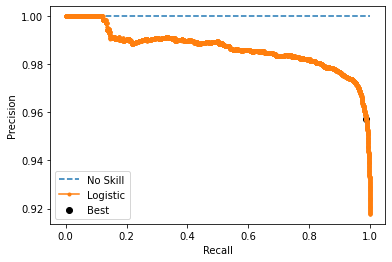

In [ ]:
# optimal threshold for precision-recall curve with logistic regression model
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot

precision, recall, thresholds = precision_recall_curve(y_eval, y_preds)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_eval[y_eval==1]) / len(y_eval)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
roc_auc_score(y_eval, y_preds)

0.9080180086898831

In [ ]:
pred_threshold = 0.5
result_label=[]

for element in y_preds['predictions']:
    if(element>pred_threshold):
        result_label.append(1)
    else:
        result_label.append(0)
print(result_label)
f1_score(y_eval, result_label)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

0.9708643887329398

In [ ]:
true_list=[]
true_index=[]
false_list=[]
false_index=[]
print(y_preds)
for i in range(len(y_eval)):
    if(y_eval[i]==1):
        true_list.append(y_preds['predictions'][i])
        true_index.append(len(true_index))
    else:
        false_list.append(y_preds['predictions'][i])
        false_index.append(len(false_index))
print(true_list)
print(false_list)
print(true_index)
print(false_index)

from matplotlib import pyplot


pyplot.scatter( true_index,true_list,  marker='o', color='black', label='Best')
pyplot.show()
pyplot.scatter( false_index,false_list,  marker='x', color='red', label='Best')
pyplot.show()

In [ ]:
true_list=[]
true_index=[]
false_list=[]
false_index=[]
for i in range(len(y_eval)):
    if(y_eval.iloc[i,0]==1):
        true_list.append(y_preds.iloc[i,0])
        true_index.append(len(true_index))
    else:
        false_list.append(y_preds.iloc[i,0])
        false_index.append(len(false_index))


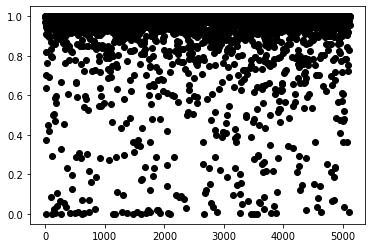

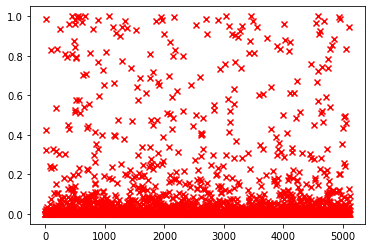

In [ ]:
from matplotlib import pyplot

y_preds.head()
X_eval.head()

pyplot.scatter( true_index,true_list,  marker='o', color='black', label='Best')
pyplot.show()
pyplot.scatter( false_index,false_list,  marker='x', color='red', label='Best')
pyplot.show()

In [ ]:

model.fit(features_df_preprocess, label_df)
test_probas = model.predict_proba(test_features_df_preprocess)

In [ ]:
pred_threshold = 0.38
result_label=[]

for element in test_probas[:,1]:
    if(element>pred_threshold):
        result_label.append(1)
    else:
        result_label.append(0)

In [ ]:
y_preds = pd.DataFrame(
    {
        "prediction": map(int,np.round(test_probas[:,1]))
        #"prediction": result_label
    },
    index = test_features_df.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (8576, 1)


,prediction
tripid,
213284604,1
213286352,1
213293973,1
213294622,1
213298687,1


In [ ]:
submission_df = pd.read_csv(DATA_PATH / "/content/drive/My Drive/Fare Classification/sample_submission.csv", 
                            index_col="tripid")

In [ ]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["prediction"] = y_preds
submission_df.head()

,prediction
tripid,
213284604,1
213286352,1
213293973,1
213294622,1
213298687,1


In [ ]:
submission_df.to_csv('Nuradha_160449N_XX.csv', index=True)